In [56]:
import random
import csv
import math
import numpy as np
import time
import operator
import matplotlib.pyplot as plt
import cPickle as pickle
import heapq

In [2]:
live_edges_200k_point001_point3_steps = pickle.load(open("live_edges_200k_point001_point3_steps", "rb"))
#print "ni hao"
live_edges_200k_point001_point5_steps = pickle.load(open("live_edges_200k_point001_point5_steps", "rb"))
print "hello"

live_edges_200k_point005_point3_steps = pickle.load(open("live_edges_200k_point005_point3_steps", "rb"))
print "hi"

live_edges_200k_point005_point5_steps = pickle.load(open("live_edges_200k_point005_point5_steps", "rb"))

hello
hi


# CELF

In [52]:
def celf_steps_live_edges(p_initial_infect, p_infect, lists_infected_dicts, num_detectors, n=2029, debug=False):
    
    runs_per_marginal_node = len(lists_infected_dicts)
    
    print 'Running CELF to minimize simulation steps w/ live edges'
    results = open("CELF_steps_live_edges.txt", "w")
    results.write("P_infect = " + str(p_infect) + " P_initial_infect = " + str(p_initial_infect) + " Runs per marginal node = " + str(runs_per_marginal_node))
    results.write("\nNode ID\tReward so Far\tMarginal gain\tRuntime (minutes)\n")
    
    final_steps = []
    final_runtimes = []
    
    rewards_so_far = 39265
    
    marginals = []
    start_time = time.time()
    
    # how to calculate simulation steps: look thru the keys in the dictionary, if it is not in the keys, then we automatically fill it w/ the max number of simulation steps
    for potential_detector in range(1,n+1): # calculate marginals for each node
        runs = [infected_dict[potential_detector] if potential_detector in infected_dict.keys() else 39265 for infected_dict in lists_infected_dicts]
        heapq.heappush(marginals, (sum(runs)/float(runs_per_marginal_node) - rewards_so_far, potential_detector))
    
    best_tuple = heapq.heappop(marginals)
    best_node = best_tuple[1]
    marginal = best_tuple[0]
    rewards_so_far = marginal + rewards_so_far
    runtime = ( time.time() - start_time ) / 60
    selected_detectors = [best_node] # we have found our first best node
    
    print "We have our first best node: "
    print selected_detectors
    print "Runtime (minutes) = " + str( runtime )
    final_steps.append(rewards_so_far)
    final_runtimes.append(runtime)
    
    results.write(str(best_node) + '\t' + str(rewards_so_far) + '\t' + str(marginal) + '\t' + str(runtime) + '\n' )
    
    for i in range(1, num_detectors): # select the next 19 detectors
        
        if debug:
            print "Trying to find the " + str(i+1) + "th detector"
        
        # need to re-evaluate the top node once, at least
        old_top_tuple = heapq.heappop(marginals)
        old_top_node = old_top_tuple[1]
        new_detectors = list(selected_detectors)
        new_detectors.append(old_top_node)

        # lazily evaluate for the top node
        runs = [] # records the results for each run
        for run in range(runs_per_marginal_node): # go thru the runs
            infected_dict = lists_infected_dicts[run]
            if bool(set(new_detectors) & set(infected_dict.keys() )): # detector is in the set of infected ids
                alerted_detectors = set(new_detectors) & set(infected_dict.keys() )  # grab the set of detectors that was alerted
                alert_times = [infected_dict[detector] for detector in alerted_detectors]
                runs.append(min(alert_times)) # get the first time of alert
            else: # outbreak not detected, so last simulation step
                runs.append(39265)
            
        heapq.heappush(marginals, (sum(runs) / float(runs_per_marginal_node) - rewards_so_far, old_top_node))
        new_top_tuple = heapq.heappop(marginals)
        new_top_node = new_top_tuple[1]
        
        while new_top_node != old_top_node: # this is where we need to re-evaluate the next top node
            old_top_node = new_top_node
            new_detectors = list(selected_detectors)
            new_detectors.append(old_top_node)
            
            runs = [] # records number of runs
            for run in range(runs_per_marginal_node): # go thru the runs
                infected_dict = lists_infected_dicts[run]
                if bool(set(new_detectors) & set(infected_dict.keys())): # detector is in the set of infected ids
                    alerted_detectors = set(new_detectors) & set(infected_dict.keys() ) # grab the set of detectors that was alerted
                    alert_times = [infected_dict[detector] for detector in alerted_detectors]
                    runs.append(min(alert_times)) # get the first time of alert
                else: # outbreak not detected, so last simulation step
                    runs.append(39265)            
            
            heapq.heappush(marginals, (sum(runs) / float(runs_per_marginal_node) - rewards_so_far, old_top_node))

            new_top_tuple = heapq.heappop(marginals)
            new_top_node = new_top_tuple[1]
        
        best_node = new_top_node
        
        print "After doing CELF, we have found the " + str (i+1) + "th detector w/ best marginal gain = " + str(best_node)
        selected_detectors.append(best_node)
        runtime = (time.time() - start_time)/60
        rewards_so_far = rewards_so_far + new_top_tuple[0] # update the rewards w/ the marginals gained by the current node
        results.write(str(best_node) + '\t' + str(rewards_so_far) + '\t' + str(new_top_tuple[0]) + '\t' + str(runtime) + '\n')
        final_steps.append(rewards_so_far)
        final_runtimes.append(runtime)
        print "Simulation steps so far: " + str(rewards_so_far)
        print "Runtime (minutes) = " + str(runtime)
        
        
            
    results.close()
    return final_steps, final_runtimes
    

# Pure Social Score

In [29]:
def social_steps_live_edges(p_initial_infect, p_infect, lists_infected_dicts, num_detectors):

    final_steps = []
    final_runtimes = []
    
    with open("socialScore_modified_unpruned.txt") as social_file:
        lines = social_file.readlines()
        social_score_nodes = []
        for line in lines:
            social_score_nodes.append( int(line.split()[0]) )
    runs_per_marginal_node = len(lists_infected_dicts)
            
    rewards_so_far = 0
    marginal = 0
    start_time = time.time()
    selected_detectors = []
    for next_detector in range(num_detectors):
        selected_detectors.append(social_score_nodes[next_detector]) # add the next detector
        
        runs = [] # records number of runs
        for run in range(runs_per_marginal_node): # go thru the runs
            infected_dict = lists_infected_dicts[run]
            if bool(set(selected_detectors) & set(infected_dict.keys())): # detector is in the set of infected ids
                alerted_detectors = set(selected_detectors) & set(infected_dict.keys() ) # grab the set of detectors that was alerted
                alert_times = [infected_dict[detector] for detector in alerted_detectors]
                runs.append(min(alert_times)) # get the first time of alert
            else: # outbreak not detected, so last simulation step
                runs.append(39265) 
                    
        steps = sum(runs) / float(runs_per_marginal_node)
        marginal = steps - rewards_so_far
        rewards_so_far = steps
        final_steps.append(rewards_so_far)
        print "After doing Social Score, we have found the " + str(next_detector+1) + "th detector = " + str(social_score_nodes[next_detector])
        print "Population affected so far: " + str(rewards_so_far)
        print "Marginal gain = " + str(marginal)
        runtime = (time.time() - start_time) / 60
        print "Runtime (minutes) = " + str(runtime)
        final_runtimes.append(runtime)
    
    return final_steps, final_runtimes



# Speed up

In [39]:
def speedup_steps_live_edges(p_initial_infect, p_infect, lists_infected_dicts, num_detectors, social_score_file, seed=0, n=2029, debug=False):
    
    runs_per_marginal_node = len(lists_infected_dicts)
    final_steps = []
    final_runtimes = []
    
    print 'Running Speedup to minimize steps affected w/ live edges'
    results = open("Speedup_steps_live_edge.txt", "w")
    results.write("P_infect = " + str(p_infect) + " P_initial_infect = " + str(p_initial_infect) + " Runs per marginal node = " + str(runs_per_marginal_node))
    results.write("\nNode ID\tReward so Far\tMarginal gain\tRuntime (minutes)\n")
    
    rewards_so_far = 39265
    
    marginals = [] # heap to track marginals
    
    # how we keep track of the social score nodes
    social_score_nodes = []
    with open(social_score_file) as social_file:
        lines = social_file.readlines()
        for line in lines:
            social_score_nodes.append( int(line.split()[0]) )   
   
    
    look_ahead = int(math.sqrt(n)) # how much we look ahead
    start_time = time.time()
    
    # we are calculated population saved
    # if the detector is in the infected nodes, we take the index of the detector b/c the infected nodes are in chronological order + 1 - length to represent how many we saved
    # if not, we just take 0 b/c we didnt save any
    # select the first node by exhuastively computing all marginal benefits
    # our metric = (population affected w/ detector) - population affected w/o detector
    # we are trying to minimize this metric
    for potential_detector in social_score_nodes[:look_ahead]: # calculate marginals for each node
        runs = [infected_dict[potential_detector] if potential_detector in infected_dict.keys() else 39265 for infected_dict in lists_infected_dicts]
        heapq.heappush(marginals, (sum(runs)/float(runs_per_marginal_node) - rewards_so_far, potential_detector))

        
    
    best_tuple = heapq.heappop(marginals)
    best_node = best_tuple[1]
    marginal = best_tuple[0]
    rewards_so_far = marginal + rewards_so_far
    
    selected_detectors = [best_node] # we have found our first best node
    
    print "We have our first best node: "
    print selected_detectors
    runtime = (time.time() - start_time) / 60
    print "Runtime (minutes) = " + str( runtime )
    final_steps.append(rewards_so_far)
    final_runtimes.append(runtime)
    
    results.write(str(best_node) + '\t' + str(rewards_so_far) + '\t' + str(marginal) + '\t' + str(runtime) + '\n' )
    
    for i in range(1, num_detectors): # select the next num_detectors-1 detectors
        
        if debug:
            print "Trying to find the " + str(i+1) + "th detector"
        
        # add one new detector from social score
        new_detectors=list(selected_detectors)
        additional_detector = social_score_nodes[look_ahead - 1 + i]
        new_detectors.append(additional_detector)
        runs = [] # records the results for each run
        for run in range(runs_per_marginal_node): # go thru the runs
            infected_dict = lists_infected_dicts[run]
            if bool(set(new_detectors) & set(infected_dict.keys())): # detector is in the set of infected ids
                alerted_detectors = set(new_detectors) & set(infected_dict.keys() ) # grab the set of detectors that was alerted
                alert_times = [infected_dict[detector] for detector in alerted_detectors]
                runs.append(min(alert_times)) # get the first time of alert
            else: # outbreak not detected, so last simulation step
                runs.append(39265) 
        heapq.heappush(marginals, (sum(runs) / float(runs_per_marginal_node) - rewards_so_far, additional_detector))
        
        
        # need to re-evaluate the top node once, at least
        old_top_tuple = heapq.heappop(marginals)
        old_top_node = old_top_tuple[1]
        new_detectors = list(selected_detectors)
        new_detectors.append(old_top_node)

        # lazily evaluate for the top node
        runs = [] # records the results for each run
        for run in range(runs_per_marginal_node): # go thru the runs
            infected_dict = lists_infected_dicts[run]
            if bool(set(new_detectors) & set(infected_dict.keys())): # detector is in the set of infected ids
                alerted_detectors = set(new_detectors) & set(infected_dict.keys() ) # grab the set of detectors that was alerted
                alert_times = [infected_dict[detector] for detector in alerted_detectors]
                runs.append(min(alert_times)) # get the first time of alert
            else: # outbreak not detected, so last simulation step
                runs.append(39265) 
        heapq.heappush(marginals, (sum(runs) / float(runs_per_marginal_node) - rewards_so_far, old_top_node))

        new_top_tuple = heapq.heappop(marginals)
        new_top_node = new_top_tuple[1]
        
        while new_top_node != old_top_node: # this is where we need to re-evaluate the next top node
            old_top_node = new_top_node
            new_detectors = list(selected_detectors)
            new_detectors.append(old_top_node)
            
            runs = [] # records number of runs
            for run in range(runs_per_marginal_node): # go thru the runs
                infected_dict = lists_infected_dicts[run]
                if bool(set(new_detectors) & set(infected_dict.keys())): # detector is in the set of infected ids
                    alerted_detectors = set(new_detectors) & set(infected_dict.keys() ) # grab the set of detectors that was alerted
                    alert_times = [infected_dict[detector] for detector in alerted_detectors]
                    runs.append(min(alert_times)) # get the first time of alert
                else: # outbreak not detected, so last simulation step
                    runs.append(39265)           
            heapq.heappush(marginals, (sum(runs) / float(runs_per_marginal_node) - rewards_so_far, old_top_node))
           
            new_top_tuple = heapq.heappop(marginals)
            new_top_node = new_top_tuple[1]
        
        
        
        best_node = new_top_node
        
        print "After doing speed up, we have found the " + str (i+1) + "th detector w/ best marginal gain = " + str(best_node)
        selected_detectors.append(best_node)
        runtime = (time.time() - start_time)/60
        rewards_so_far = rewards_so_far + new_top_tuple[0] # update the rewards w/ the marginals gained by the current node
        results.write(str(best_node) + '\t' + str(rewards_so_far) + '\t' + str(new_top_tuple[0]) + '\t' + str(runtime) + '\n')
        final_steps.append(rewards_so_far)
        final_runtimes.append(runtime)
        print "Steps so far: " + str(rewards_so_far)
        print "Runtime (minutes) = " + str(runtime)
        
        
        
            
    results.close()
    
    return final_steps, final_runtimes

# Comparisons

P_initial = 0.001, p_infect = 0.3

In [61]:
celf_steps_point001_point3, celf_steps_runtimes_point001_point3 = celf_steps_live_edges(0.001, 0.3, live_edges_200k_point001_point3_steps[:100000], 50)

Running CELF to minimize simulation steps w/ live edges
We have our first best node: 
[1144]
Runtime (minutes) = 17.9052666664
After doing CELF, we have found the 2th detector w/ best marginal gain = 246
Simulation steps so far: 28578.39235
Runtime (minutes) = 55.7424333334
After doing CELF, we have found the 3th detector w/ best marginal gain = 453
Simulation steps so far: 28110.29731
Runtime (minutes) = 58.8507166664
After doing CELF, we have found the 4th detector w/ best marginal gain = 1377
Simulation steps so far: 27856.34935
Runtime (minutes) = 62.2191833337
After doing CELF, we have found the 5th detector w/ best marginal gain = 1952
Simulation steps so far: 27654.73046
Runtime (minutes) = 63.7808999976
After doing CELF, we have found the 6th detector w/ best marginal gain = 547
Simulation steps so far: 27484.3336
Runtime (minutes) = 65.1190999985
After doing CELF, we have found the 7th detector w/ best marginal gain = 1701
Simulation steps so far: 27359.96267
Runtime (minutes)

In [42]:
social_steps_point001_point3, social_steps_runtimes_point001_point3 = social_steps_live_edges(0.001, 0.3, live_edges_200k_point001_point3_steps[:100000], 50)

After doing Social Score, we have found the 1th detector = 1874
Population affected so far: 29512.99308
Marginal gain = 29512.99308
Runtime (minutes) = 0.0524000008901
After doing Social Score, we have found the 2th detector = 1258
Population affected so far: 29483.4094
Marginal gain = -29.58368
Runtime (minutes) = 0.0998000025749
After doing Social Score, we have found the 3th detector = 1669
Population affected so far: 29141.06965
Marginal gain = -342.33975
Runtime (minutes) = 0.146250001589
After doing Social Score, we have found the 4th detector = 999
Population affected so far: 29132.53719
Marginal gain = -8.53246
Runtime (minutes) = 0.191683336099
After doing Social Score, we have found the 5th detector = 511
Population affected so far: 29125.24371
Marginal gain = -7.29348
Runtime (minutes) = 0.23990000089
After doing Social Score, we have found the 6th detector = 852
Population affected so far: 29118.1774
Marginal gain = -7.06631
Runtime (minutes) = 0.288916667302
After doing So

In [43]:
speedup_steps_point001_point3, speedup_steps_runtimes_point001_point3 = speedup_steps_live_edges(0.001, 0.3, live_edges_200k_point001_point3_steps[:100000], 50, "socialScore_modified_unpruned.txt")

Running Speedup to minimize steps affected w/ live edges
We have our first best node: 
[1144]
Runtime (minutes) = 0.354999999205
After doing speed up, we have found the 2th detector w/ best marginal gain = 453
Steps so far: 28870.81012
Runtime (minutes) = 2.43146666686
After doing speed up, we have found the 3th detector w/ best marginal gain = 1706
Steps so far: 28775.95358
Runtime (minutes) = 3.17048333089
After doing speed up, we have found the 4th detector w/ best marginal gain = 1874
Steps so far: 28700.19695
Runtime (minutes) = 3.53876666625
After doing speed up, we have found the 5th detector w/ best marginal gain = 1159
Steps so far: 28636.52781
Runtime (minutes) = 3.95586666663
After doing speed up, we have found the 6th detector w/ best marginal gain = 278
Steps so far: 28576.75248
Runtime (minutes) = 4.096116666
After doing speed up, we have found the 7th detector w/ best marginal gain = 1669
Steps so far: 28534.94855
Runtime (minutes) = 4.56894999743
After doing speed up, w

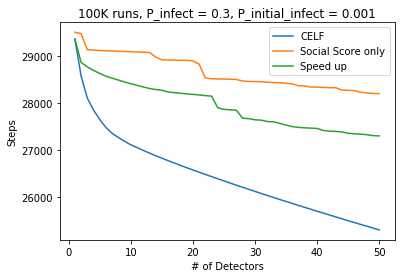

In [65]:
plt.plot(range(1, 51), celf_steps_point001_point3, label="CELF")
plt.plot(range(1, 51), social_steps_point001_point3, label="Social Score only")
plt.plot(range(1, 51), speedup_steps_point001_point3, label="Speed up")
plt.title("100K runs, P_infect = 0.3, P_initial_infect = 0.001")
plt.ylabel("Steps")
plt.xlabel("# of Detectors")
plt.legend()

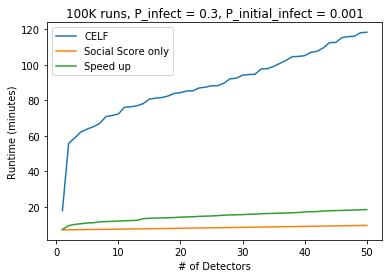

In [67]:
plt.plot(range(1, 51), celf_steps_runtimes_point001_point3, label="CELF")
plt.plot(range(1, 51), [runtime + 7 for runtime in social_steps_runtimes_point001_point3], label="Social Score only")
plt.plot(range(1, 51), [runtime + 7 for runtime in speedup_steps_runtimes_point001_point3], label="Speed up")
plt.title("100K runs, P_infect = 0.3, P_initial_infect = 0.001")
plt.ylabel("Runtime (minutes)")
plt.xlabel("# of Detectors")
plt.legend()

P_initial = 0.001, p_infect = 0.5

In [62]:
celf_steps_point001_point5, celf_steps_runtimes_point001_point5 = celf_steps_live_edges(0.001, 0.5, live_edges_200k_point001_point5_steps[:100000], 50)

Running CELF to minimize simulation steps w/ live edges
We have our first best node: 
[1144]
Runtime (minutes) = 26.0339833339
After doing CELF, we have found the 2th detector w/ best marginal gain = 246
Simulation steps so far: 25914.20782
Runtime (minutes) = 84.3203500032
After doing CELF, we have found the 3th detector w/ best marginal gain = 453
Simulation steps so far: 25509.47764
Runtime (minutes) = 88.6718833367
After doing CELF, we have found the 4th detector w/ best marginal gain = 1377
Simulation steps so far: 25232.3635
Runtime (minutes) = 92.8760333339
After doing CELF, we have found the 5th detector w/ best marginal gain = 1952
Simulation steps so far: 24993.38746
Runtime (minutes) = 94.5322000027
After doing CELF, we have found the 6th detector w/ best marginal gain = 547
Simulation steps so far: 24807.55646
Runtime (minutes) = 96.9879000028
After doing CELF, we have found the 7th detector w/ best marginal gain = 1701
Simulation steps so far: 24658.35909
Runtime (minutes)

In [63]:
social_steps_point001_point5, social_steps_runtimes_point001_point5 = social_steps_live_edges(0.001, 0.5, live_edges_200k_point001_point5_steps[:100000], 50)

After doing Social Score, we have found the 1th detector = 1874
Population affected so far: 27086.78681
Marginal gain = 27086.78681
Runtime (minutes) = 0.0646499991417
After doing Social Score, we have found the 2th detector = 1258
Population affected so far: 27066.38034
Marginal gain = -20.40647
Runtime (minutes) = 0.129933333397
After doing Social Score, we have found the 3th detector = 1669
Population affected so far: 26763.22523
Marginal gain = -303.15511
Runtime (minutes) = 0.195216667652
After doing Social Score, we have found the 4th detector = 999
Population affected so far: 26757.31017
Marginal gain = -5.91506
Runtime (minutes) = 0.262150001526
After doing Social Score, we have found the 5th detector = 511
Population affected so far: 26750.2407
Marginal gain = -7.06947
Runtime (minutes) = 0.327566667398
After doing Social Score, we have found the 6th detector = 852
Population affected so far: 26745.93966
Marginal gain = -4.30104
Runtime (minutes) = 0.393900001049
After doing S

In [68]:
speedup_steps_point001_point5, speedup_steps_runtimes_point001_point5 = speedup_steps_live_edges(0.001, 0.5, live_edges_200k_point001_point5_steps[:100000], 50 , "socialScore_modified_unpruned.txt")

Running Speedup to minimize steps affected w/ live edges
We have our first best node: 
[1144]
Runtime (minutes) = 0.518450001876
After doing speed up, we have found the 2th detector w/ best marginal gain = 453
Steps so far: 26542.69549
Runtime (minutes) = 3.36601666609
After doing speed up, we have found the 3th detector w/ best marginal gain = 1706
Steps so far: 26459.10878
Runtime (minutes) = 4.45660000245
After doing speed up, we have found the 4th detector w/ best marginal gain = 278
Steps so far: 26393.27798
Runtime (minutes) = 5.09806666772
After doing speed up, we have found the 5th detector w/ best marginal gain = 895
Steps so far: 26338.71249
Runtime (minutes) = 5.35315000216
After doing speed up, we have found the 6th detector w/ best marginal gain = 1874
Steps so far: 26286.02819
Runtime (minutes) = 5.61161666711
After doing speed up, we have found the 7th detector w/ best marginal gain = 480
Steps so far: 26240.06512
Runtime (minutes) = 6.06731666724
After doing speed up, w

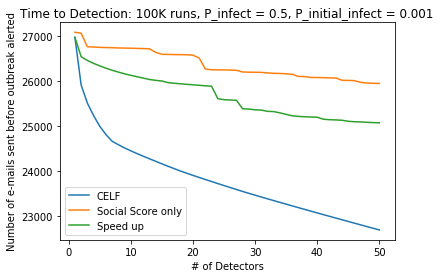

In [76]:
plt.plot(range(1, 51), celf_steps_point001_point5, label="CELF")
plt.plot(range(1, 51), social_steps_point001_point5, label="Social Score only")
plt.plot(range(1, 51), speedup_steps_point001_point5, label="Speed up")
plt.title("Time to Detection: 100K runs, P_infect = 0.5, P_initial_infect = 0.001")
plt.ylabel("Number of e-mails sent before outbreak alerted")
plt.xlabel("# of Detectors")
plt.legend()

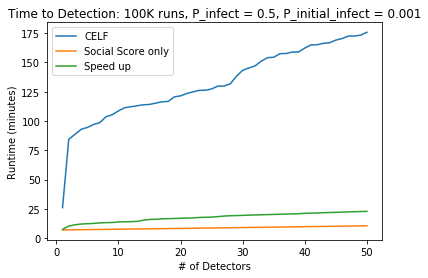

In [74]:
plt.plot(range(1, 51), celf_steps_runtimes_point001_point5, label="CELF")
plt.plot(range(1, 51), [runtime + 7 for runtime in social_steps_runtimes_point001_point5], label="Social Score only")
plt.plot(range(1, 51), [runtime + 7 for runtime in speedup_steps_runtimes_point001_point5], label="Speed up")
plt.title("Time to Detection: 100K runs, P_infect = 0.5, P_initial_infect = 0.001")
plt.ylabel("Runtime (minutes)")
plt.xlabel("# of Detectors")
plt.legend()

P_initial = 0.005, p_infect = 0.3

In [86]:
celf_steps_point005_point3, celf_steps_runtimes_point005_point3 = celf_steps_live_edges(0.005, 0.3, live_edges_200k_point005_point3_steps[:5000], 50)

Running CELF to minimize simulation steps w/ live edges
We have our first best node: 
[1144]
Runtime (minutes) = 2.61251666546
After doing CELF, we have found the 2th detector w/ best marginal gain = 246
Simulation steps so far: 10004.5096
Runtime (minutes) = 8.1751000007
After doing CELF, we have found the 3th detector w/ best marginal gain = 453
Simulation steps so far: 9276.1362
Runtime (minutes) = 8.62683333158
After doing CELF, we have found the 4th detector w/ best marginal gain = 1377
Simulation steps so far: 8992.2336
Runtime (minutes) = 9.92818333308
After doing CELF, we have found the 5th detector w/ best marginal gain = 1952
Simulation steps so far: 8744.2168
Runtime (minutes) = 10.5408166687
After doing CELF, we have found the 6th detector w/ best marginal gain = 547
Simulation steps so far: 8545.2592
Runtime (minutes) = 12.3945000013
After doing CELF, we have found the 7th detector w/ best marginal gain = 1874
Simulation steps so far: 8373.9026
Runtime (minutes) = 13.88103

In [70]:
social_steps_point005_point3, social_steps_runtimes_point005_point3 = social_steps_live_edges(0.005, 0.3, live_edges_200k_point005_point3_steps[:100000], 50)

After doing Social Score, we have found the 1th detector = 1874
Population affected so far: 11783.81206
Marginal gain = 11783.81206
Runtime (minutes) = 0.115649998188
After doing Social Score, we have found the 2th detector = 1258
Population affected so far: 11720.20255
Marginal gain = -63.60951
Runtime (minutes) = 0.233250002066
After doing Social Score, we have found the 3th detector = 1669
Population affected so far: 11135.7366
Marginal gain = -584.46595
Runtime (minutes) = 0.349766667684
After doing Social Score, we have found the 4th detector = 999
Population affected so far: 11113.25294
Marginal gain = -22.48366
Runtime (minutes) = 0.467616665363
After doing Social Score, we have found the 5th detector = 511
Population affected so far: 11094.18283
Marginal gain = -19.07011
Runtime (minutes) = 0.585266665618
After doing Social Score, we have found the 6th detector = 852
Population affected so far: 11073.00844
Marginal gain = -21.17439
Runtime (minutes) = 0.704899998506
After doing

In [69]:
speedup_steps_point005_point3, speedup_steps_runtimes_point005_point3 = speedup_steps_live_edges(0.005, 0.3, live_edges_200k_point005_point3_steps[:100000], 50, "socialScore_modified_unpruned.txt")

Running Speedup to minimize steps affected w/ live edges
We have our first best node: 
[1144]
Runtime (minutes) = 1.02029999892
After doing speed up, we have found the 2th detector w/ best marginal gain = 453
Steps so far: 10734.70472
Runtime (minutes) = 6.23491666714
After doing speed up, we have found the 3th detector w/ best marginal gain = 1874
Steps so far: 10530.4524
Runtime (minutes) = 8.32471666733
After doing speed up, we have found the 4th detector w/ best marginal gain = 1159
Steps so far: 10379.1074
Runtime (minutes) = 9.83768333197
After doing speed up, we have found the 5th detector w/ best marginal gain = 1706
Steps so far: 10231.45298
Runtime (minutes) = 10.4218666673
After doing speed up, we have found the 6th detector w/ best marginal gain = 895
Steps so far: 10103.50373
Runtime (minutes) = 11.369266665
After doing speed up, we have found the 7th detector w/ best marginal gain = 278
Steps so far: 9980.26963
Runtime (minutes) = 11.6061833342
After doing speed up, we ha

In [81]:
celf_10k_runtimes = celf_steps_runtimes_point005_point3

In [87]:
celf_5k_runtimes = celf_steps_runtimes_point005_point3

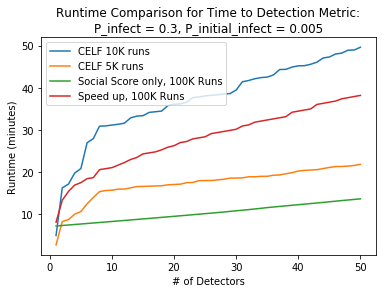

In [89]:
plt.plot(range(1, 51), celf_10k_runtimes, label="CELF 10K runs")
plt.plot(range(1, 51), celf_5k_runtimes, label="CELF 5K runs")
plt.plot(range(1, 51), [runtime + 7 for runtime in social_steps_runtimes_point005_point3], label="Social Score only, 100K Runs")
plt.plot(range(1, 51), [runtime + 7 for runtime in speedup_steps_runtimes_point005_point3], label="Speed up, 100K Runs")
plt.title("Runtime Comparison for Time to Detection Metric:\nP_infect = 0.3, P_initial_infect = 0.005")
plt.ylabel("Runtime (minutes)")
plt.xlabel("# of Detectors")
plt.legend()